# Diffusion Kurtosis Imaging

The diffusion kurtosis model is an expansion of the diffusion tensor model ([Jensen et al. 2005](https://pubmed.ncbi.nlm.nih.gov/15906300/)). In addition to the diffusion tensor (DT), the diffusion kurtosis model quantifies the degree to which water diffusion in biological tissues is non-Gaussian using the kurtosis tensor (KT).

Measurements of non-Gaussian diffusion from the diffusion kurtosis model are of interest because they can be used to charaterize tissue microstructural heterogeneity ([Jensen and Helpern. 2010](https://pubmed.ncbi.nlm.nih.gov/20632416/)). These measures may better relate to microstructural alteration in health and diseases than measures based on the total diffusion anisotropy which is highly confounded by dispersion and crossing alterations. Moreover, they also the characterization of tissues with low diffusion anisotropy such as regions of Grey matter.

In the following example we show how to fit the diffusion kurtosis model on diffusion-weighted multi-shell datasets and how to estimate diffusion kurtosis based metrics.

First, we import all relevant modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
from dipy.core.gradients import gradient_table
from dipy.data import get_fnames
from dipy.io.gradients import read_bvals_bvecs
from dipy.io.image import load_nifti
from dipy.segment.mask import median_otsu
from scipy.ndimage.filters import gaussian_filter

DKI requires multi-shell data, i.e. data acquired from more than one non-zero b-value. Here, we use fetch to download a multi-shell dataset which was kindly provided by Hansen and Jespersen (more details about the data are provided in their paper [Hansen2016](https://www.nature.com/articles/sdata201672)). The total size of the downloaded data is 192 MBytes, however you only need to fetch it once.

In [2]:
fraw, fbval, fbvec, t1_fname = get_fnames('cfin_multib')

data, affine = load_nifti(fraw)
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
gtab = gradient_table(bvals, bvecs)

Before fitting the data, we preform some data pre-processing. We first compute a brain mask to avoid unnecessary calculations on the background of the image.

In [3]:
maskdata, mask = median_otsu(data, vol_idx=[0, 1], median_radius=4, numpass=2,
                             autocrop=False, dilate=1)

Since the diffusion kurtosis models involves the estimation of a large number of parameters ([TaxCMW2015](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.25165)) and since the non-Gaussian components of the diffusion signal are more sensitive to artefacts ([NetoHe2012](https://core.ac.uk/download/pdf/12428129.pdf)), it might be favorable to suppress the effects of noise and artefacts before diffusion kurtosis fitting. In this example the effects of noise and artefacts are suppress by using 3D Gaussian smoothing (with a Gaussian kernel with fwhm=1.25) as suggested by pioneer DKI studies (e.g. [Jensen2005](https://pubmed.ncbi.nlm.nih.gov/15906300/), [NetoHe2012](https://core.ac.uk/download/pdf/12428129.pdf)). Although here the Gaussian smoothing is used so that results are comparable to these studies, it is important to note that more advanced noise and artifact suppression algorithms are available in DIPY, e.g. the Marcenko-Pastur PCA denoising algorithm ([example-denoise-mppca](https://dipy.org/documentation/1.3.0./examples_built/denoise_mppca/#example-denoise-mppca)) and the Gibbs artefact suppression algorithm ([example-denoise-gibbs](https://dipy.org/documentation/1.3.0./examples_built/denoise_gibbs/#example-denoise-gibbs)).

In [4]:
fwhm = 1.25
gauss_std = fwhm / np.sqrt(8 * np.log(2))  # converting fwhm to Gaussian std
data_smooth = np.zeros(data.shape)
for v in range(data.shape[-1]):
    data_smooth[..., v] = gaussian_filter(data[..., v], sigma=gauss_std)

Now that we have loaded and pre-processed the data we can go forward with DKI fitting. For this, the DKI model is first defined for the data’s GradientTable object by instantiating the DiffusionKurtosisModel object in the following way:

In [5]:
dkimodel = dki.DiffusionKurtosisModel(gtab)

To fit the data using the defined model object, we call the "fit" function of this object:

In [6]:
dkifit = dkimodel.fit(data_smooth, mask=mask)

The fit method creates a DiffusionKurtosisFit object, which contains all the diffusion and kurtosis fitting parameters and other DKI attributes. For instance, since the diffusion kurtosis model estimates the diffusion tensor, all diffusion standard tensor statistics can be computed from the DiffusionKurtosisFit instance. For example, we show below how to extract the fractional anisotropy (FA), the mean diffusivity (MD), the axial diffusivity (AD) and the radial diffusivity (RD) from the DiffusionKurtosisiFit instance.

In [7]:
FA = dkifit.fa
MD = dkifit.md
AD = dkifit.ad
RD = dkifit.rd

Note that these four standard measures could also be computed from DIPY’s DTI module. Computing these measures from both models should be analogous; however, theoretically, the diffusion statistics from the kurtosis model are expected to have better accuracy, since DKI’s diffusion tensor are decoupled from higher order terms effects ([Veraar2011](https://pubmed.ncbi.nlm.nih.gov/20878760/), [NetoHe2012](https://core.ac.uk/download/pdf/12428129.pdf)). For comparison purposes, we calculate below the FA, MD, AD, and RD using DIPY’s TensorModel.

In [8]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data_smooth, mask=mask)

dti_FA = tenfit.fa
dti_MD = tenfit.md
dti_AD = tenfit.ad
dti_RD = tenfit.rd

The DT based measures can be easily visualized using matplotlib. For example, the FA, MD, AD, and RD obtained from the diffusion kurtosis model (upper panels) and the tensor model (lower panels) are plotted for a selected axial slice. DTI’s diffusion estimates present lower values than DKI’s estimates, showing that DTI’s diffusion measurements are underestimated by higher order effects.

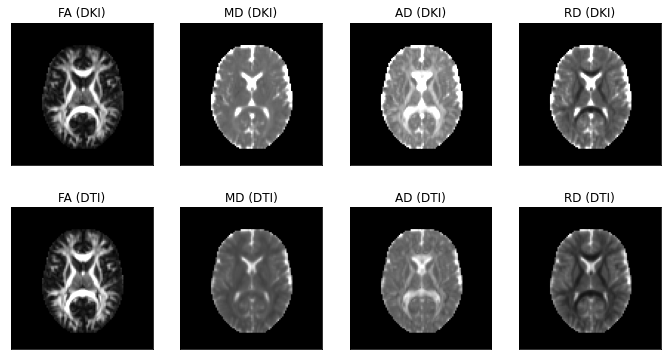

In [9]:
axial_slice = 9

fig1, ax = plt.subplots(2, 4, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig1.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[0].set_title('FA (DKI)')
ax.flat[1].imshow(MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[1].set_title('MD (DKI)')
ax.flat[2].imshow(AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[2].set_title('AD (DKI)')
ax.flat[3].imshow(RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[3].set_title('RD (DKI)')

ax.flat[4].imshow(dti_FA[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=0.7, origin='lower')
ax.flat[4].set_title('FA (DTI)')
ax.flat[5].imshow(dti_MD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[5].set_title('MD (DTI)')
ax.flat[6].imshow(dti_AD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[6].set_title('AD (DTI)')
ax.flat[7].imshow(dti_RD[:, :, axial_slice].T, cmap='gray',
                  vmin=0, vmax=2.0e-3, origin='lower')
ax.flat[7].set_title('RD (DTI)')

plt.show()
fig1.savefig('Diffusion_tensor_measures_from_DTI_and_DKI.png')

In addition to the standard diffusion statistics, the DiffusionKurtosisFit instance can be used to estimate the non-Gaussian measures of mean kurtosis (MK), the axial kurtosis (AK) and the radial kurtosis (RK).

Kurtosis measures are susceptible to high amplitude outliers. The impact of high amplitude kurtosis outliers can be removed by introducing as an optional input the extremes of the typical values of kurtosis. Here these are assumed to be on the range between 0 and 3):

In [10]:
MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)

Now we are ready to plot the kurtosis standard measures using matplotlib:

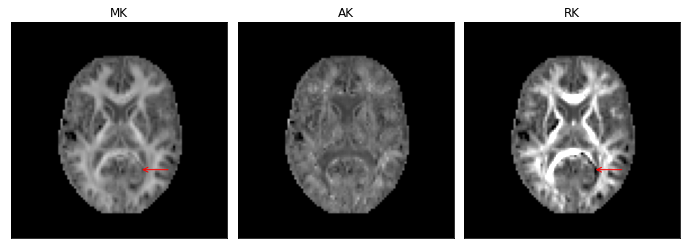

In [11]:
fig2, ax = plt.subplots(1, 3, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig2.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MK')
ax.flat[0].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
ax.flat[1].imshow(AK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('AK')
ax.flat[2].imshow(RK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[2].set_title('RK')
ax.flat[2].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

plt.show()
fig2.savefig('Kurtosis_tensor_standard_measures.png')

The non-Gaussian behaviour of the diffusion signal is expected to be higher when tissue water is confined by multiple compartments. MK is, therefore, higher in white matter since it is highly compartmentalized by myelin sheaths. These water diffusion compartmentalization is expected to be more pronounced prependicularly to white matter fibers and thus the RK map presents higher amplitudes than the AK map.

It is important to note that kurtosis estimates might presented negative estimates in deep white matter regions (e.g. red arrow added in the figure above). This negative kurtosis values are artefactual and might be induced by: 1) low radial diffusivities of aligned white matter - since it is very hard to capture non-Gaussian information in radial direction due to it’s low diffusion decays, radial kurtosis estimates (and consequently the mean kurtosis estimates) might have low robustness and tendency to exhibit negative values ([NetoHe2012](https://core.ac.uk/download/pdf/12428129.pdf)); 2) Gibbs artefacts - MRI images might be corrupted by signal oscilation artefact between tissue’s edges if an inadequate number of high frequencies of the k-space is sampled. These oscilations might have different signs on images acquired with different diffusion-weighted and inducing negative biases in kurtosis parametric maps ([Perron2015](https://www.sciencedirect.com/science/article/abs/pii/S105381191500573X?via%3Dihub)), ([NetoHe2018](https://www.repository.cam.ac.uk/handle/1810/281993)).

One can try to suppress this issue by using the more advance noise and artefact suppression algorithms, e.g., as mentioned above, the MP-PCA denoising ([example-denoise-mppca](https://dipy.org/documentation/1.3.0./examples_built/denoise_mppca/#example-denoise-mppca)) and Gibbs Unringing ([example-denoise-gibbs](https://dipy.org/documentation/1.3.0./examples_built/denoise_gibbs/#example-denoise-gibbs)) algorithms. Alternatively, one can overcome this artefact by computing the kurtosis values from powder-averaged diffusion-weighted signals. The details on how to compute the kurtosis from powder-average signals in dipy are described in follow the tutorial ([example-reconst-msdki](https://dipy.org/documentation/1.3.0./examples_built/reconst_msdki/#example-reconst-msdki)).

### Exercise

Alternatively, to quantify non-Gaussian diffusion in a more robust way, one can estimate a scalar kurtosis value from powder-averaged diffusion-weighted signals, instead of fitting the full kurtosis tensor. This scalar kurtosis was defined as the mean signal kurtosis index (msk), [NetoHe2018](https://www.repository.cam.ac.uk/handle/1810/281993). In Dipy, the mean signal diffusiona kurtosis imaging model is defined by MeanDiffusionKurtosisModel and can be called from dipy.reconst.msdki. 

In the following exercise let's compute the standard mean kurtosis and MSK index from the non-smoothed data and compare its results by plotting them for an axial slice of the brain.

Note: The details on how to compute the kurtosis from powder-average signals in dipy are described in follow the tutorial ([example-reconst-msdki](https://dipy.org/documentation/1.3.0./examples_built/reconst_msdki/#example-reconst-msdki)).

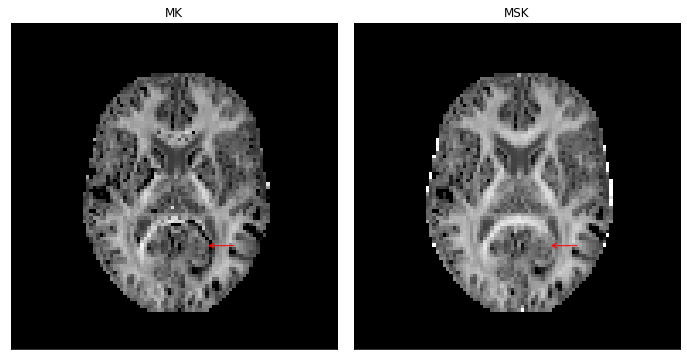

In [14]:
# Compute standard mean kurtosis from the non-smooth data
# (Insert your code below)
dkifit = dkimodel.fit(data, mask=mask)

MK = dkifit.mk(0, 3)
AK = dkifit.ak(0, 3)
RK = dkifit.rk(0, 3)

# Compute the mean signal kurtosis index from the non-smooth data
# (Insert your code below)
from dipy.reconst.msdki import MeanDiffusionKurtosisModel
msdki_model = MeanDiffusionKurtosisModel(gtab)
msdki_fit = msdki_model.fit(data, mask=mask)
MSK = msdki_fit.msk

# Plot the data
fig3, ax = plt.subplots(1, 2, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

fig3.subplots_adjust(hspace=0.3, wspace=0.05)

ax.flat[0].imshow(MK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[0].set_title('MK')
ax.flat[0].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))
ax.flat[1].imshow(MSK[:, :, axial_slice].T, cmap='gray', vmin=0, vmax=1.5,
                  origin='lower')
ax.flat[1].set_title('MSK')
ax.flat[1].annotate('', fontsize=12, xy=(57, 30),
                    color='red',
                    xycoords='data', xytext=(30, 0),
                    textcoords='offset points',
                    arrowprops=dict(arrowstyle="->",
                                    color='red'))

plt.show()
fig3.savefig('msk_vs_dki.png')